In [10]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
print("Training data shape:", x_train.shape) 
print("Test data shape:", x_test.shape) 


Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)


In [11]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [12]:
model = models.Sequential()

In [13]:
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

C:\Users\kybav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [15]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
history = model.fit(x_train, y_train, epochs=10, 
                    validation_data=(x_test, y_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.7444 - loss: 0.6932 - val_accuracy: 0.8647 - val_loss: 0.3799
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - accuracy: 0.8813 - loss: 0.3248 - val_accuracy: 0.8779 - val_loss: 0.3227
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 49s 18ms/step - accuracy: 0.9001 - loss: 0.2716 - val_accuracy: 0.8975 - val_loss: 0.2829
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.9097 - loss: 0.2429 - val_accuracy: 0.9037 - val_loss: 0.2740
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - accuracy: 0.9220 - loss: 0.2120 - val_accuracy: 0.9005 - val_loss: 0.2710
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9295 - loss: 0.1895 - val_accuracy: 0.9068 - val_loss: 0.2721
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9364 - loss: 0.1739 - val_accuracy: 0.9043 - val_loss: 0.2677
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.9398 -

In [17]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9106 - loss: 0.2772
Test accuracy: 0.9124000072479248


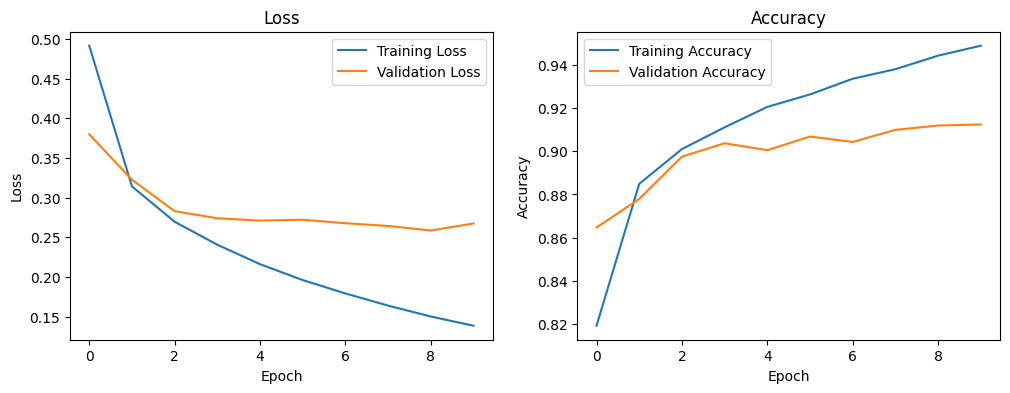

In [18]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()